In [1]:
import os
import glob
import random
import numpy as np
import torch as th
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F

In [2]:
import torchvision
from torch.utils import data
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, datasets

Dataset 2

The data is a zip folder of GIF images of tumor cells from 20 patients.

The following diagnoses were recorded for the following patient IDs:

Benign:
	92_751 
	92_5311
	92_5292
	92_5291
	92_5277
	92_5236
	92_4964
	92_4934
	92_4632
	92_4342

Malignant:
	92_7241
	92_6954
	92_6682
	92_6424
	92_6125
	92_5622
	91_9555
	91_6838
	91_6799
	91_5691

In [3]:
pwd = "./Exercise2 - data/cancer_images/"
files = os.listdir(pwd)

In [4]:
benign = ["92_751", "92_5311", "92_5292", "92_5291", "92_5277", "92_5236", "92_4964", "92_4934", "92_4632", "92_4342"]
benign = [i + ".gif" for i in benign]

In [5]:
malign = ["92_7241", "92_6954", "92_6682", "92_6424", "92_6125", "92_5622", "91_9555", "91_6838", "91_6799", "91_5691"]
malign = [i + ".gif" for i in malign]

0 benign
1 malign

In [6]:
images = []
images.extend((Image.open(pwd + b), 0)  for b in benign)
images.extend((Image.open(pwd + m), 1)  for m in malign)

In [7]:
test_set = random.sample(range(len(images)), 5)

In [8]:
test_set

[6, 16, 7, 17, 19]

In [9]:
train_set = [i for i in range(len(images)) if i not in test_set]

In [10]:
train_set

[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 18]

I decided to use a simple CNN to solve this problem. 
The dataset is small, so we should apply heavy data-augmentation. In this case a segmentation pipeline (similar to U-Net) could help to better discriminate between classes.

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(13984, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 2)
        self.init_parameters()

    def forward(self, x, flag=None):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 4)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out_un = out.clone()
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        if flag == "un":
            return out, out_un
        return out

    def init_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

data loader to clean the code. We apply augmentation using transform

In [13]:
class Loader(data.Dataset):

    def __init__(self, images, split, transform=None):
        self.n_classes = 2
        self.images = images
        self.split = split
        self.transform = transform
        
    def __len__(self):
        return len(self.split)

    def __getitem__(self, index):

        img = self.images[self.split[index]][0]
        lbl = self.images[self.split[index]][1]
        
        if self.transform is not None:
            img = self.transform(img)
        img = np.array(img, float)
        img = img / 255.0
        
        img = np.reshape(img, (1, img.shape[0], img.shape[1]))
        img = th.from_numpy(img)
        return img, lbl

In [14]:
model = Net().double()
criterion = nn.CrossEntropyLoss()

size_original = (400, 640)
data_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip()])

dataset_train = Loader(images, train_set, transform=data_transform)
dataset_test  = Loader(images, test_set)
trainloader   = data.DataLoader(dataset_train, batch_size=5, shuffle=True)
testloader    = data.DataLoader(dataset_test, batch_size=1, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
optimizer.zero_grad()

for epoch in range(30):
    print("epoch: ", epoch)
    model.train()
    acc = []
    for i_iter, batch in enumerate(trainloader):
        optimizer.zero_grad()
        image, label = batch

        pred = model(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        y_pred = th.argmax(pred, dim=1)
        acc.extend([(y_pred == label).numpy()])
    print("train acc: ", np.mean(acc))
    model.eval()
    acc = []
    for i_iter, batch in enumerate(testloader):
        image, label = batch
        pred = model(image)
        y_pred = th.argmax(pred)
        acc.extend([y_pred == label])
    print("test acc: ", np.mean(acc))

epoch:  0
train acc:  0.533333333333
test acc:  0.4
epoch:  1
train acc:  0.8
test acc:  0.6
epoch:  2
train acc:  0.466666666667
test acc:  0.6
epoch:  3
train acc:  0.533333333333
test acc:  0.8
epoch:  4
train acc:  0.533333333333
test acc:  0.4
epoch:  5
train acc:  0.666666666667
test acc:  0.8
epoch:  6
train acc:  0.733333333333
test acc:  0.8
epoch:  7
train acc:  0.733333333333
test acc:  0.8
epoch:  8
train acc:  0.733333333333
test acc:  0.6
epoch:  9
train acc:  0.733333333333
test acc:  0.8
epoch:  10
train acc:  0.733333333333
test acc:  0.8
epoch:  11
train acc:  0.8
test acc:  0.8
epoch:  12
train acc:  0.733333333333
test acc:  0.6
epoch:  13
train acc:  0.733333333333
test acc:  0.8
epoch:  14
train acc:  0.733333333333
test acc:  0.8
epoch:  15
train acc:  0.8
test acc:  0.8
epoch:  16
train acc:  0.8
test acc:  0.8
epoch:  17
train acc:  0.8
test acc:  0.6
epoch:  18
train acc:  0.666666666667
test acc:  0.8
epoch:  19
train acc:  0.733333333333
test acc:  0.8
epoch

In [15]:
res = []
for i_iter, batch in enumerate(testloader):
        image, label = batch
        pred = model(image)
        y_pred = th.argmax(pred)
        res.append(int(y_pred.numpy()))

predicted class:  0
label:  0


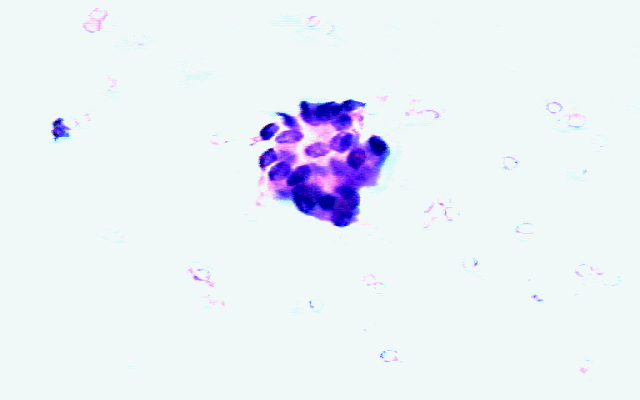

In [16]:
i = 0
print("predicted class: ", res[i])
print("label: ", images[test_set[i]][1])
images[test_set[i]][0]

predicted class:  1
label:  1


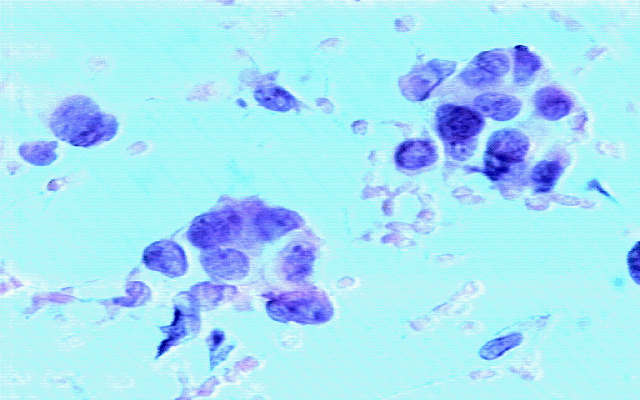

In [17]:
i = 1
print("predicted class: ", res[i])
print("label: ", images[test_set[i]][1])
images[test_set[i]][0]

predicted class:  0
label:  0


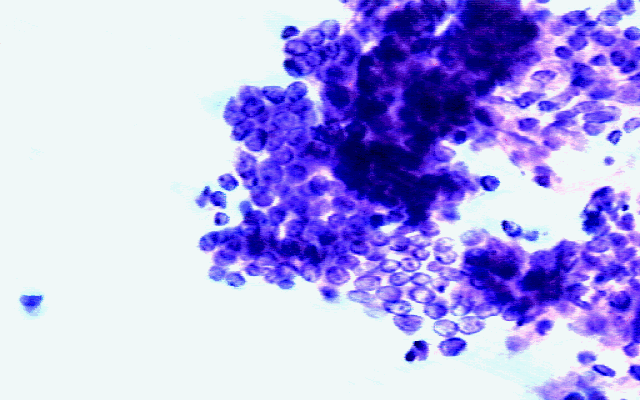

In [18]:
i = 2
print("predicted class: ", res[i])
print("label: ", images[test_set[i]][1])
images[test_set[i]][0]

predicted class:  1
label:  1


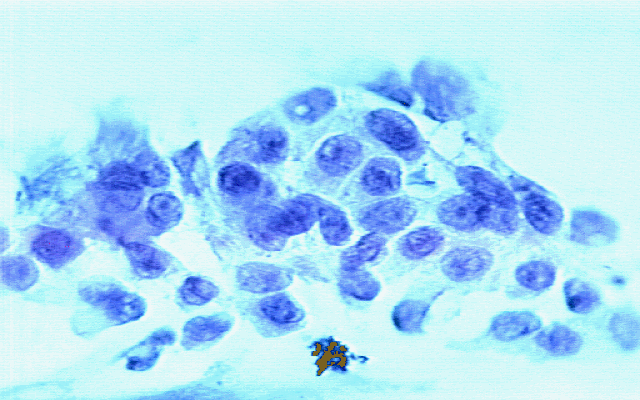

In [19]:
i = 3
print("predicted class: ", res[i])
print("label: ", images[test_set[i]][1])
images[test_set[i]][0]

Misclassification. Caused by the left zone? We could investigate with an attention mechanism.

predicted class:  0
label:  1


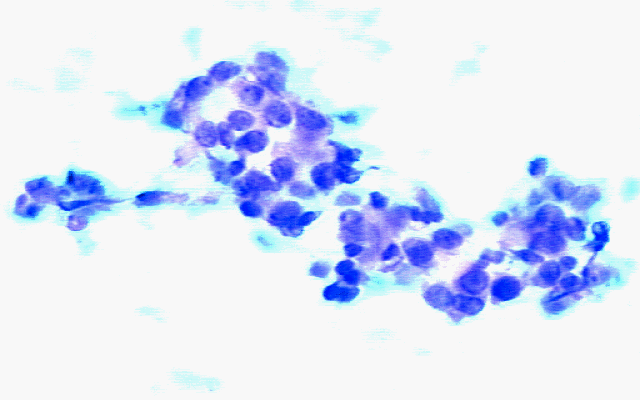

In [20]:
i = 4
print("predicted class: ", res[i])
print("label: ", images[test_set[i]][1])
images[test_set[i]][0]

try a simple unsupervised strategy. After training, extract features from the first FC layer and cluster them. We could also build an autoencoder and extract features.

In [21]:
res = []
for i_iter, batch in enumerate(testloader):
        image, label = batch
        pred, pred_un = model(image, flag="un")
        res.append(pred_un.detach().numpy())

In [22]:
features = np.array(res).squeeze()

In [23]:
features.shape

(5, 120)

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [25]:
cluster = KMeans(2, max_iter=1000)

In [26]:
cluster.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
y_pred = cluster.predict(features)

In [32]:
y_pred

array([0, 1, 0, 1, 0], dtype=int32)

In [29]:
lbl = [images[i][1] for i in test_set]

In [33]:
lbl

[0, 1, 0, 1, 1]

In [30]:
confusion_unsupervised = confusion_matrix(lbl, y_pred)

In [31]:
print(confusion_unsupervised / confusion_unsupervised.sum() * 100)

[[ 40.   0.]
 [ 20.  40.]]


distribution features for misclassified sample

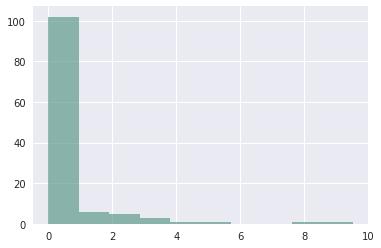

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.distplot(features[4], kde=False)
plt.show()

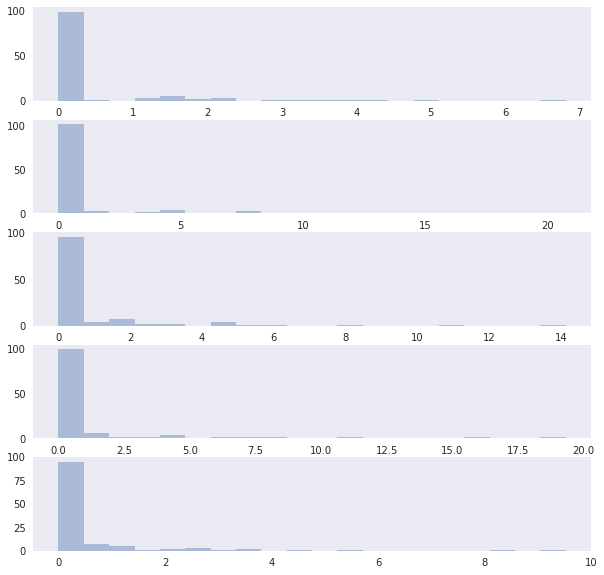

In [48]:
f, ax = plt.subplots(5, 1, figsize=(10,10))
for i in range(5):
    var = features[i]
    sns.distplot(var, kde=False, ax=ax[i], bins=20)
    ax[i].grid()
plt.show()